<a href="https://colab.research.google.com/github/yuvalofek/scraping-light-novel-data/blob/main/LN_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## An analysis of the light novel dataset I scraped 

In [163]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [164]:
DATA_PATH = '/content/drive/MyDrive/light_novel_dataset.csv'

ln_df = pd.read_csv(DATA_PATH)
ln_df.head()

,Unnamed: 0,title,Type,Genre,Tags,Language,Author(s),Artist(s),Year,Status,Description,You May Also Like,Total Views,Rating,Latest Chapters,chap_count,rand_chapter,Alternative Names,Related Series
0,0,A Bored Lich,['Web Novel'],['Fantasy'],['N/A'],['Chinese'],['Random_writer'],['N/A'],['N/A'],['Ongoing'],"['""Screw magic, I want to learn how to do cool...",['Ore ga Inmajutsu de Dorei Harem wo Tsukuru H...,['65133'],['7.3'],"['Chapter 321', ' Chapter 320', ' Chapter 319'...",321.0,5.0,NaN,NaN
1,1,A Billion Dollar Exchange,['Web Novel'],['Romance'],['N/A'],['Chinese'],['ZhiRuYi'],['N/A'],['N/A'],['Ongoing'],"['""Mr Liu Wei.."" Liling paused as she took In ...","['May Your Soul Rest in Magdala(Ongoing)', 'Fi...",['56356'],['7.7'],"['Chapter 339', ' Chapter 338', ' Chapter 337'...",339.0,31.0,NaN,NaN
2,2,"A Boy Raised by Gods, Will Be the Strongest",['Web Novel'],"['Action', 'Adventure', 'Fantasy', 'Harem', 'R...",['N/A'],['Japanese'],['Hata Ryosuke'],['N/A'],['N/A'],['Ongoing'],['Will was a boy left to his fate in the middl...,"['So Pure, So Flirtatious(Ongoing)', 'The Roma...",['14834'],['7.8'],"['Chapter 15', ' Chapter 14', ' Chapter 13', '...",15.0,1.0,"['Kamigami ni Sodaterare Shimo no, Saikyou to ...",NaN
3,3,A Book Dedicated to Our Youth,['Chinese Novel'],"['Josei', 'Romance']","['Bullying', 'First Love', 'Smart Female Lead']",['Chinese'],['Tong Hua'],['Tong Hua'],['2010'],['Ongoing'],['There are always moments far in the past tha...,['Harmless Obsession for the Captivating Male ...,['26740'],['2.6'],"['Epilogue', ' Chapter 8.3', ' Chapter 8.2', '...",4.0,49.0,"['Time Will Never Go Back', '那些回不去的年少时光']",NaN
4,4,A Barbaric Proposal,['Web Novel'],"['Drama', 'Fantasy', 'Josei', 'Romance']",['N/A'],['Korean'],['齐成琨'],['N/A'],['N/A'],['Ongoing'],"['“I already have a child with another man.”',...","['GosickS(Ongoing)', 'My Forgiving Fiancee Is ...",['24791'],['7.5'],"['Chapter 52', ' Chapter 51', ' Chapter 50', '...",52.0,15.0,['ABP 야만의 청혼'],NaN


## Cleaning the data
* Drop unamed column
* We need to remove the \[ \] on a bunch of the columns
* Readers -> int
* Rating, chap_count -> float
* Drop random chapter (as the word count data didn't get saved)
* One hot some of the columns (genre, type, tags, language)
* Format description for NLP



In [165]:
# drop extra index col
ln_df.drop('Unnamed: 0', axis=1, inplace=True)
ln_df.drop('rand_chapter', axis=1, inplace=True)

In [166]:
for col in ln_df.columns:
  if ln_df[col].dtype == type(object):
    # if we have an object type, remove the brackets and \'
    ln_df[col] = ln_df[col].str.replace("\[|\]|\'", '')

In [167]:
ln_df.head()

,title,Type,Genre,Tags,Language,Author(s),Artist(s),Year,Status,Description,You May Also Like,Total Views,Rating,Latest Chapters,chap_count,Alternative Names,Related Series
0,A Bored Lich,Web Novel,Fantasy,N/A,Chinese,Random_writer,N/A,N/A,Ongoing,"""Screw magic, I want to learn how to do cool f...",Ore ga Inmajutsu de Dorei Harem wo Tsukuru Han...,65133,7.3,"Chapter 321, Chapter 320, Chapter 319, Chap...",321.0,NaN,NaN
1,A Billion Dollar Exchange,Web Novel,Romance,N/A,Chinese,ZhiRuYi,N/A,N/A,Ongoing,"""Mr Liu Wei.."" Liling paused as she took In a ...","May Your Soul Rest in Magdala(Ongoing), Findin...",56356,7.7,"Chapter 339, Chapter 338, Chapter 337, Chap...",339.0,NaN,NaN
2,"A Boy Raised by Gods, Will Be the Strongest",Web Novel,"Action, Adventure, Fantasy, Harem, Romance, Sh...",N/A,Japanese,Hata Ryosuke,N/A,N/A,Ongoing,Will was a boy left to his fate in the middle ...,"So Pure, So Flirtatious(Ongoing), The Romantic...",14834,7.8,"Chapter 15, Chapter 14, Chapter 13, Chapter...",15.0,"Kamigami ni Sodaterare Shimo no, Saikyou to Na...",NaN
3,A Book Dedicated to Our Youth,Chinese Novel,"Josei, Romance","Bullying, First Love, Smart Female Lead",Chinese,Tong Hua,Tong Hua,2010,Ongoing,There are always moments far in the past that ...,Harmless Obsession for the Captivating Male Le...,26740,2.6,"Epilogue, Chapter 8.3, Chapter 8.2, Chapter...",4.0,"Time Will Never Go Back, 那些回不去的年少时光",NaN
4,A Barbaric Proposal,Web Novel,"Drama, Fantasy, Josei, Romance",N/A,Korean,齐成琨,N/A,N/A,Ongoing,"“I already have a child with another man.”, It...","GosickS(Ongoing), My Forgiving Fiancee Is a Co...",24791,7.5,"Chapter 52, Chapter 51, Chapter 50, Chapter...",52.0,ABP 야만의 청혼,NaN


### One-hotting

In [168]:
def get_unique_from_lists(col, delimiter=','):
  """
  Take a column whose values are lists split by delimiter and finds the unique
  values across all the lists
  """
  # split the string on \, , explode to get each on a different index, remove "/'"s, strip, and get unique values
  genres_ = ln_df[col].str.split(delimiter).explode().str.strip().unique().tolist()
  # remove empty string
  genres_.remove('')  
  return genres_

#### Genre

In [169]:
### Genre_list
genres = get_unique_from_lists('Genre')

In [170]:
# create a column for each genre and see if the novel has the genre
for genre in genres:
  ln_df['Genre_'+genre] = ln_df['Genre'].str.find(genre) != -1
ln_df.drop('Genre', axis=1, inplace=True)

#### Tags

In [171]:
### Genre_list
tags = get_unique_from_lists('Tags')

In [172]:
for tag in tags:
  ln_df['Tag_'+tag] = ln_df['Tags'].str.find(tag) != -1
ln_df.drop('Tags', axis=1, inplace=True)

#### Some column drops

In [173]:
# Drop novels with na chapter counts --> indicates that the novel is either too short for our analysis
# Or is formatted differently than we expect
ln_df = ln_df[~ln_df['chap_count'].isna()]

### Casting

In [174]:
ln_df['Total Views']= ln_df['Total Views'].astype(int)
ln_df['Rating']= ln_df['Rating'].astype(float)
ln_df['chap_count']= ln_df['chap_count'].astype(int)


##### Strings to lists

In [175]:
ln_df['You May Also Like'] = ln_df['You May Also Like'].str.split(',')
ln_df['Latest Chapters'] = ln_df['Latest Chapters'].str.split(',')


In [176]:
ln_df.head()

,title,Type,Language,Author(s),Artist(s),Year,Status,Description,You May Also Like,Total Views,Rating,Latest Chapters,chap_count,Alternative Names,Related Series,Genre_Fantasy,Genre_Romance,Genre_Action,Genre_Adventure,Genre_Harem,Genre_Shounen,Genre_Josei,Genre_Drama,Genre_Martial Arts,Genre_Slice of Life,Genre_Yaoi,Genre_Comedy,Genre_Xianxia,Genre_Xuanhuan,Genre_Historical,Genre_Mature,Genre_Wuxia,Genre_Shoujo,Genre_Supernatural,Genre_School Life,Genre_Mecha,Genre_Sci-fi,Genre_Shounen Ai,Genre_Psychological,Genre_Mystery,...,Tag_Sword Sects,Tag_Subtle Romantic Subplot,Tag_Smithing,Tag_Sadistic Teacher,Tag_Pokerface,Tag_Pill Concoction,Tag_Masochistic Training,Tag_Leveling Up,Tag_Jack Of All Trades,Tag_Hot-blooded,Tag_Farming,Tag_Cunning Protagonist,Tag_Master-Disciple Relationship,Tag_Dishonest Protagonist,Tag_Manipulative Female Lead,Tag_Ruthless Female Lead,Tag_Blind Protagonist,Tag_Egotistical Male Lead,Tag_Concubine,Tag_Fantasy World Magic,Tag_Sword And Magic,Tag_Clingy Lover,Tag_Miscarriage,Tag_Poor Female Lead,Tag_Hardworking Female Lead,Tag_Lazy Male Lead,Tag_Demon Child,Tag_Apathetic Protagonist,Tag_English Company Closed Before Completing,Tag_Forgetful Protagonist,Tag_Bibles,Tag_Pedophile,Tag_Explicit Sexual Content,Tag_deneme,Tag_Out Of Print In English,Tag_Action,Tag_Digital World,Tag_Video Game Industry,Tag_School Clubs,Tag_Search For Oneself
0,A Bored Lich,Web Novel,Chinese,Random_writer,N/A,N/A,Ongoing,"""Screw magic, I want to learn how to do cool f...",[Ore ga Inmajutsu de Dorei Harem wo Tsukuru Ha...,65133,7.3,"[Chapter 321, Chapter 320, Chapter 319, ...",321,NaN,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,A Billion Dollar Exchange,Web Novel,Chinese,ZhiRuYi,N/A,N/A,Ongoing,"""Mr Liu Wei.."" Liling paused as she took In a ...","[May Your Soul Rest in Magdala(Ongoing), Find...",56356,7.7,"[Chapter 339, Chapter 338, Chapter 337, ...",339,NaN,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,"A Boy Raised by Gods, Will Be the Strongest",Web Novel,Japanese,Hata Ryosuke,N/A,N/A,Ongoing,Will was a boy left to his fate in the middle ...,"[So Pure, So Flirtatious(Ongoing), The Roman...",14834,7.8,"[Chapter 15, Chapter 14, Chapter 13, Cha...",15,"Kamigami ni Sodaterare Shimo no, Saikyou to Na...",NaN,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,A Book Dedicated to Our Youth,Chinese Novel,Chinese,Tong Hua,Tong Hua,2010,Ongoing,There are always moments far in the past that ...,[Harmless Obsession for the Captivating Male L...,26740,2.6,"[Epilogue, Chapter 8.3, Chapter 8.2, Cha...",4,"Time Will Never Go Back, 那些回不去的年少时光",NaN,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

## Exploration

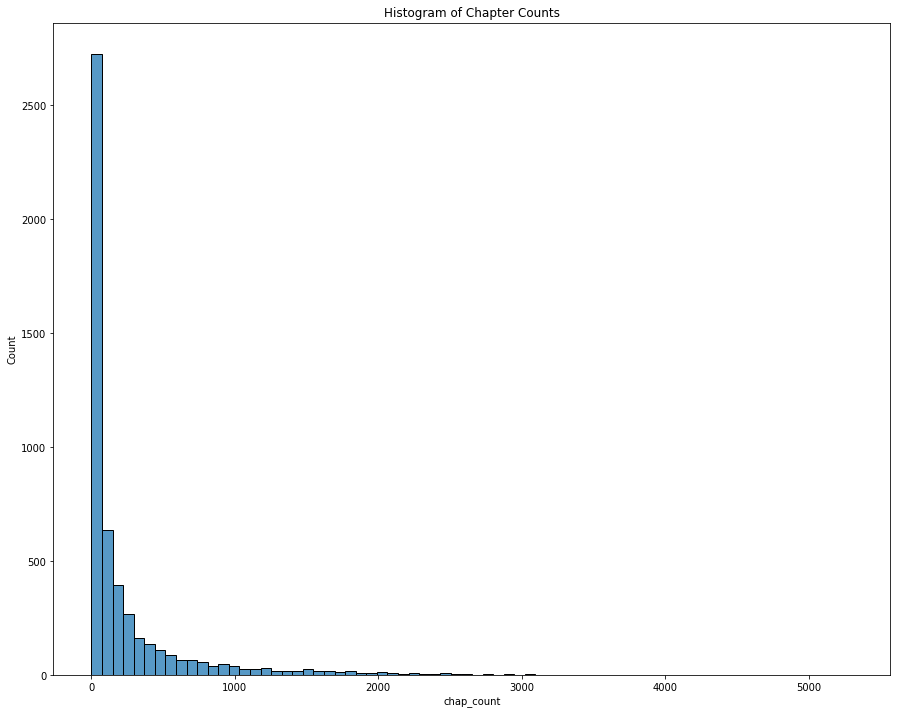

In [177]:
# Histogram of lengths
plt.figure(figsize=(15, 12))
plt.title('Histogram of Chapter Counts')
sns.histplot(ln_df['chap_count'], bins = int(np.ceil(np.sqrt(len(ln_df)))))
plt.show()

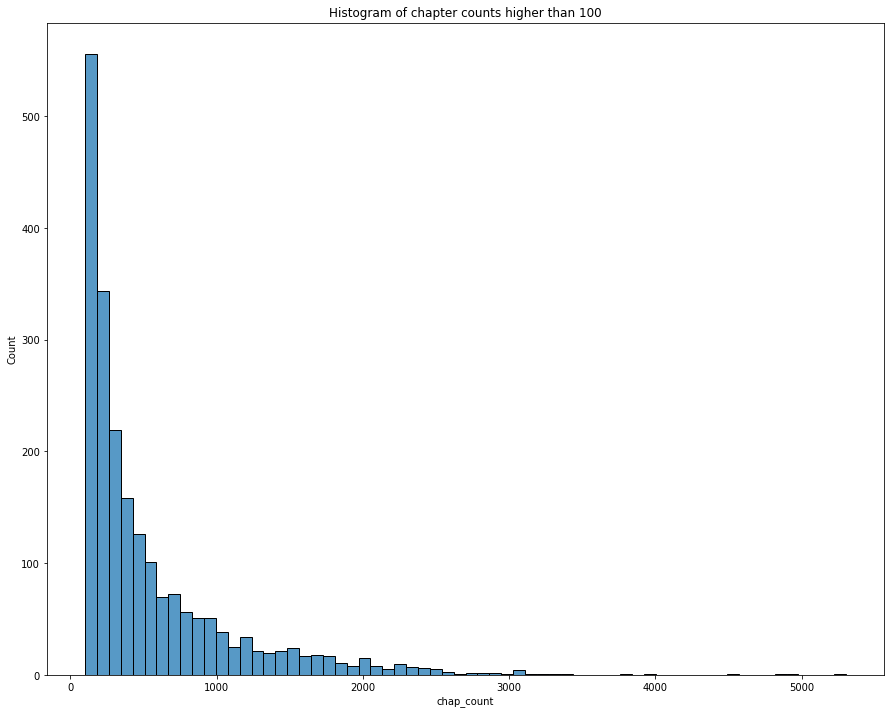

In [178]:
plt.figure(figsize=(15, 12))
plt.title('Histogram of chapter counts higher than 100')
sns.histplot(ln_df[ln_df['chap_count']>100]['chap_count'])
plt.show()

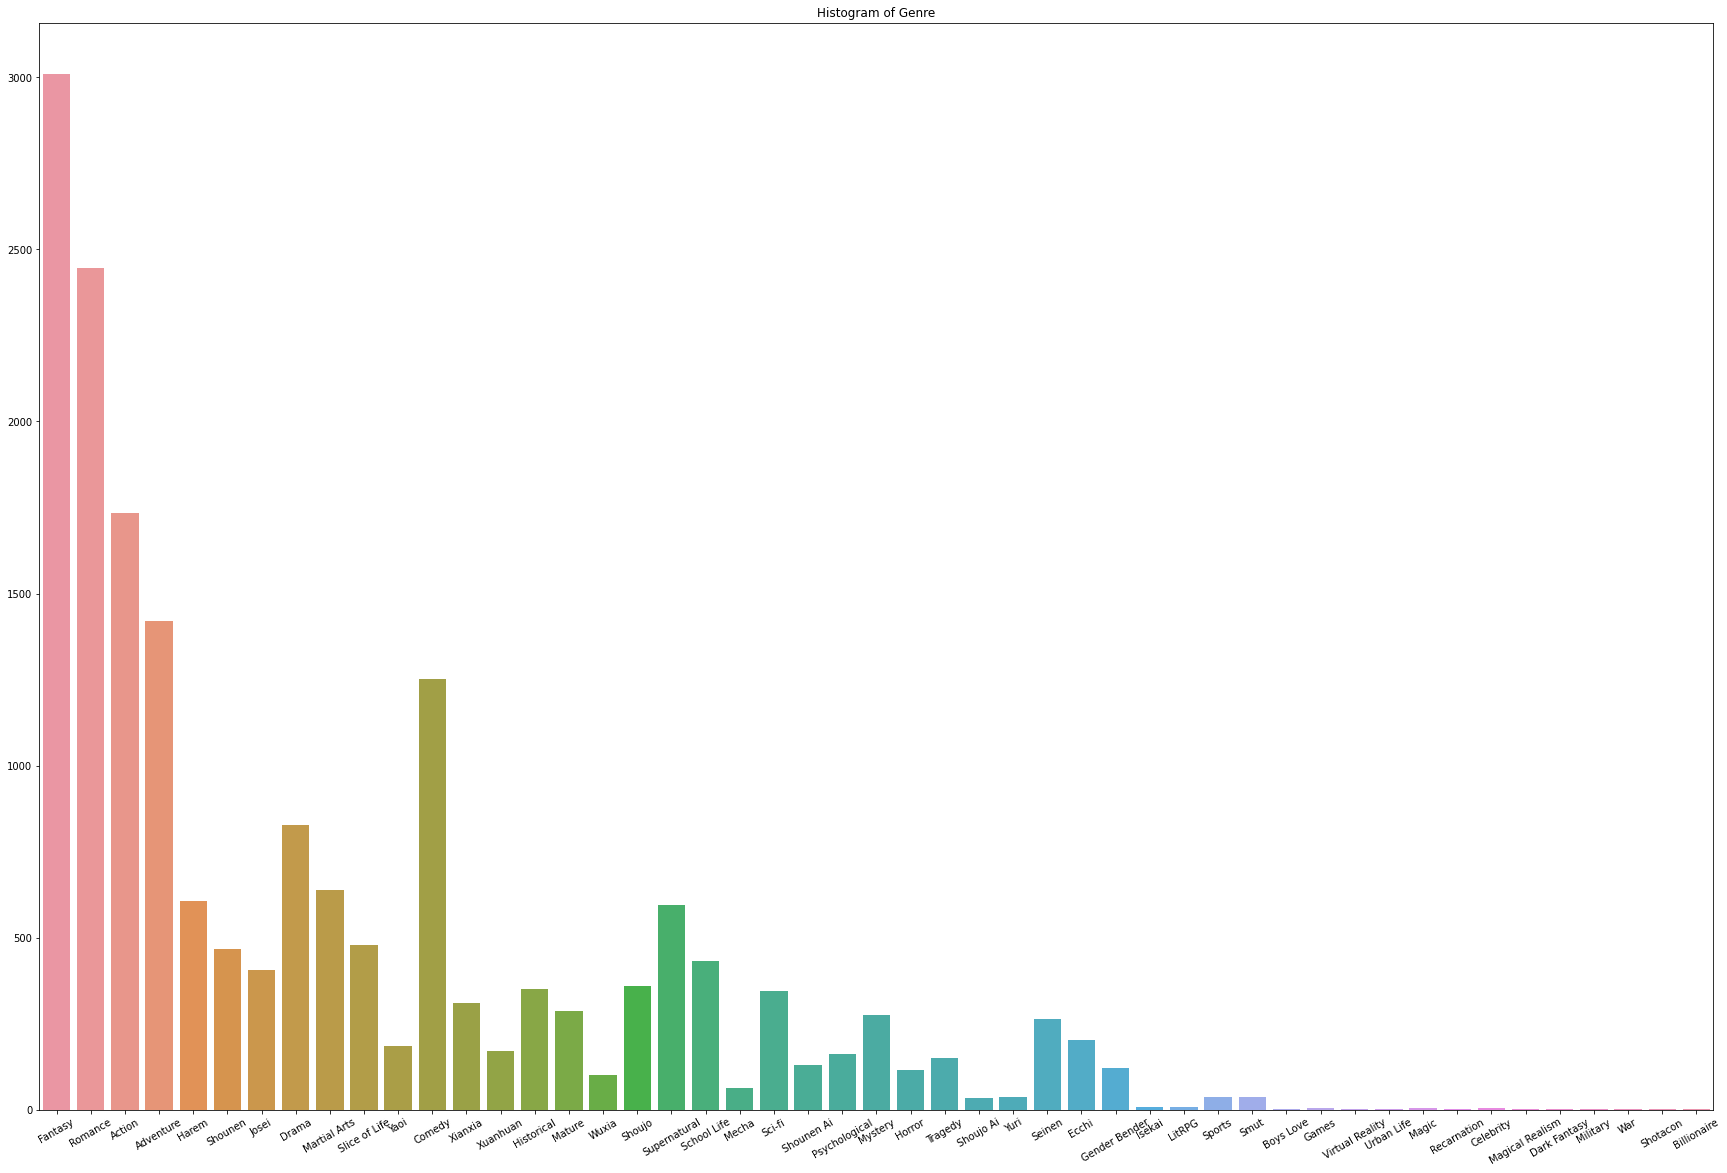

In [181]:
plt.figure(figsize=(30, 20))
plt.title('Histogram of Genre')
ax = sns.barplot(y = ln_df[[name for name in ln_df.columns if 'Genre' in name]].sum(numeric_only=True), x = [name.split('_')[-1] for name in ln_df.columns if 'Genre' in name])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.savefig('Genres.png')
plt.show()

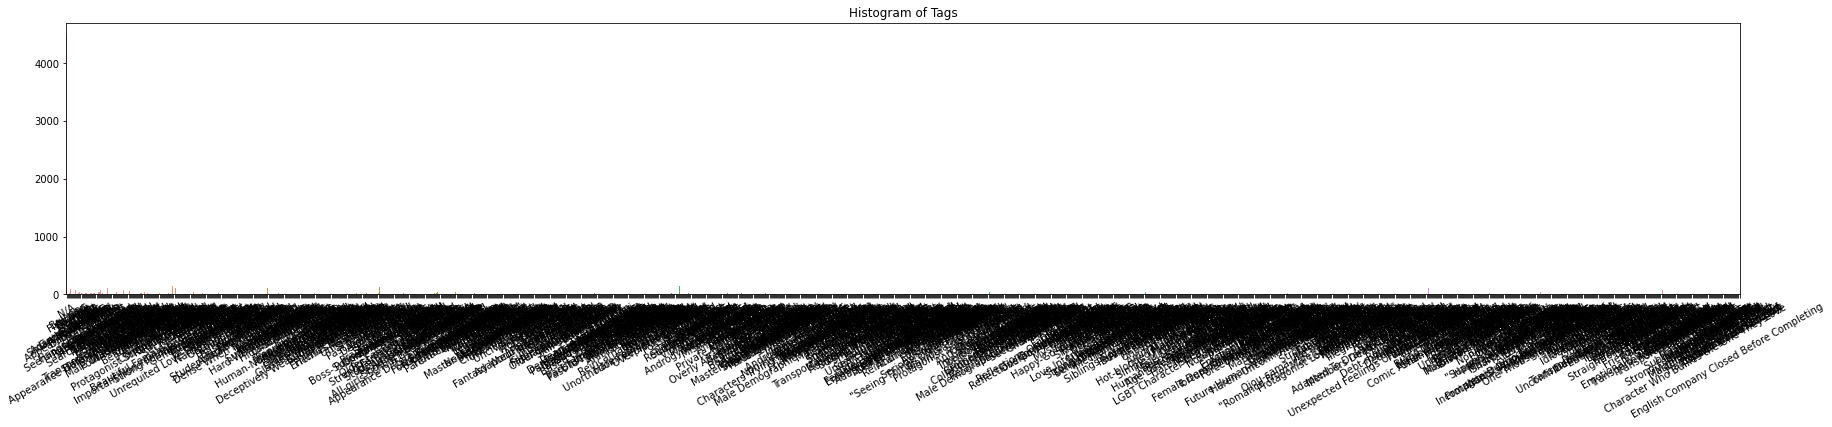

In [182]:
plt.figure(figsize=(30, 5))
plt.title('Histogram of Tags')
ax = sns.barplot(y = ln_df[[name for name in ln_df.columns if 'Tag' in name]].sum(numeric_only=True), x = [name.split('_')[-1] for name in ln_df.columns if 'Tag' in name])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.savefig('Tags.png')
plt.show()

Too many tags! Lets take those with more than 20 mentions

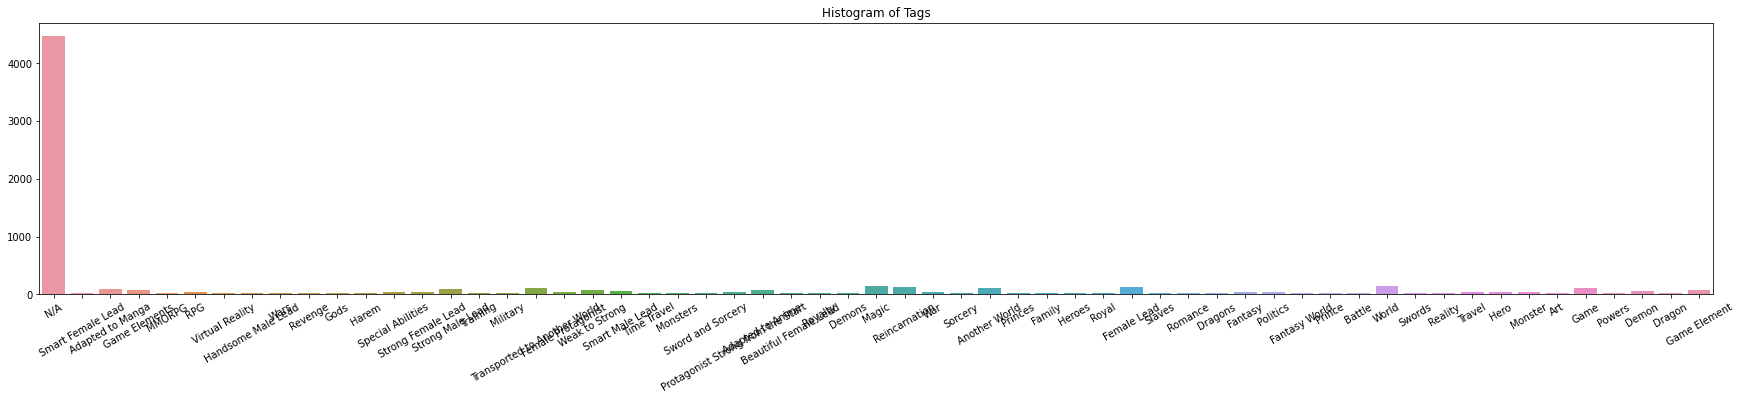

In [218]:
N = 20
tag_cols = [name for name in ln_df.columns if 'Tag' in name]
high_tag_counts = ln_df[tag_cols].loc[:, ln_df[tag_cols].sum(numeric_only=True)>N]


plt.figure(figsize=(30, 5))
plt.title('Histogram of Tags')
ax = sns.barplot(y = high_tag_counts.sum(numeric_only=True), x = [name.split('_')[-1] for name in high_tag_counts.columns if 'Tag' in name])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.savefig(f'Tags_>{N}.png')
plt.show()